In [32]:
import os
import time
import uuid
import cv2
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt
import albumentations as alb
from keras.models import Model
from keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from keras.applications import VGG16 
from keras.models import load_model
from keras.metrics import Mean


# Creating, preparing and augmenting data

## Run only once

In [105]:
# Path where images will be saved and how many of them
IMAGES_PATH = os.path.join('data','images')
number_of_images = 30

In [ ]:
# Function to take the photos
def take_photos(number_of_images):
    capture =cv2.VideoCapture(0) # Choose the device
    for n in range(number_of_images):
        print("Getting image {}".format(n))
        ret,frame = capture.read()
        image_name = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
        cv2.imwrite(image_name, frame)
        cv2.imshow('frame',frame)
        time.sleep(0.5)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    capture.release()
    cv2.destroyAllWindows()

In [ ]:
# Launch the app to label the data
# Use point label, and mark LeftEye and RightEye
!labelme

In [ ]:
# Reading images
def  load_image(path):
    byte_image = tf.io.read_file(path)
    image = tf.io.decode_jpeg(byte_image)
    return image

images = tf.data.Dataset.list_files('data\\images\\*.jpg',shuffle=False)
images = images.map(load_image)

In [ ]:
# Viewing example images
image_generator = images.batch(4).as_numpy_iterator()
plot_images = image_generator.next()

fig,ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

In [109]:
# Calculating how many images for train, test and val
print({'Test': 3 * number_of_images  *.7}) 
print({'Train': 3 * number_of_images  *.15})
print({'Val': 3 * number_of_images  *.15})  

{'Test': 62.99999999999999}
{'Train': 13.5}
{'Val': 13.5}


In [ ]:
# Now manually move images to train/test/val

In [2]:
# Moving labels after manually moving images to set folders
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data',folder, 'images')):

        name = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', name)
        
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data',folder,'labels',name)
            os.replace(existing_filepath, new_filepath)

In [16]:
# Creating augmentor for data augmentation
augmentor = alb.Compose([alb.RandomCrop(width=450,height=450),
                         alb.HorizontalFlip(p=0.5),
                         alb.RandomBrightnessContrast(p=0.3),
                         alb.RandomGamma(p=0.3),
                         alb.RGBShift(p=0.3),
                         alb.VerticalFlip(p=0.5)],
                         bbox_params=alb.BboxParams(format='albumentations', 
                                                    label_fields=['class_labels']))

In [ ]:
# Testing augmentor
image = cv2.imread(os.path.join('data', 'train', 'images', '7a25efde-f982-11ee-9516-300505ca17d6.jpg')) # Choose the existing name

with open(os.path.join('data', 'train', 'labels', '7a25efde-f982-11ee-9516-300505ca17d6.json'), 'r') as f: # Choose the existing name
    label = json.load(f)

label_points = label['shapes'][0]['points']
coordinates = [label_points[0][0], label_points[0][1], label_points[1][0], label_points[1][1]]
coordinates = list(np.divide(coordinates, [640,480,640,480]))
augmented = augmentor(image=image, bboxes=[coordinates], class_labels=['face'])

cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)),
              (255,0,0), 2)
plt.imshow(augmented['image'])

In [68]:
# Augmenting all of the data
for folder in ['train','test','val']: 
    for file in os.listdir(os.path.join('data', folder, 'images')):
        image = cv2.imread(os.path.join('data', folder, 'images', file))
       
        coordinates = [0.,0.,0.,0.]
        label_path = os.path.join('data', folder, 'labels', f'{file.split(".")[0]}.json')
        # Reading the label and coordinates
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coordinates = [label_points[0][0], label_points[0][1], label_points[1][0], label_points[1][1]]
            coordinates = list(np.divide(coordinates, [640,480,640,480]))

        try: 
            for x in range(60): # 60 times on every image
                augmented = augmentor(image=image, bboxes=[coordinates], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', folder, 'images', f'{file.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = file

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', folder, 'labels', f'{file.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

# Creating subsets

In [33]:
# Reading images
def  load_image(path):
    byte_image = tf.io.read_file(path)
    image = tf.io.decode_jpeg(byte_image)
    return image

In [34]:
# Resizing and normalizing images
def map_and_load_images(path):
    image_set = tf.data.Dataset.list_files(path, shuffle=False)
    image_set = image_set.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    image_set = image_set.map(lambda x: tf.image.resize(x, (120,120)), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    image_set = image_set.map(lambda x: x/255, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return image_set

In [35]:
# Dividng images to subsets
train_images = map_and_load_images('aug_data\\train\\images\\*.jpg')
test_images = map_and_load_images('aug_data\\test\\images\\*.jpg')
val_images = map_and_load_images('aug_data\\val\\images\\*.jpg')

In [36]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding="utf-8") as f:
        label = json.load(f)
    return [label['class']], label['bbox']

In [37]:
# Loading labels
def map_and_load_labels(path):
    label_set = tf.data.Dataset.list_files(path, shuffle=False)
    label_set = label_set.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return label_set

In [38]:
# Dividing labels to subsets
train_labels = map_and_load_labels('aug_data\\train\\labels\\*.json')
test_labels = map_and_load_labels('aug_data\\test\\labels\\*.json')
val_labels = map_and_load_labels('aug_data\\val\\labels\\*.json')

In [39]:
# Creating sets
def create_set(images, labels, n_shuffle):
    set = tf.data.Dataset.zip((images, labels))
    set = set.shuffle(n_shuffle)
    set = set.batch(8, drop_remainder=True)
    set = set.prefetch(4)
    return set

In [40]:
# Creating subsets
train = create_set(train_images, train_labels, 5000)
test = create_set(test_images, test_labels, 1300)
val = create_set(val_images, val_labels, 1000)

# Creating, building and training the model

In [41]:
# Building the model
def build_model():
    input_layer = Input(shape=(120,120,3))
    vgg = VGG16(include_top=False)(input_layer)

    # Classification
    f1 = GlobalMaxPooling2D()(vgg)
    class_layer_1 = Dense(2048, activation='relu')(f1)
    class_layer_2 = Dense(1, activation='sigmoid')(class_layer_1)

    # Regression
    f2 = GlobalMaxPooling2D()(vgg)
    regress_layer_1= Dense(2048, activation='relu')(f2)
    regress_layer_2 = Dense(4, activation='sigmoid')(regress_layer_1)

    model = Model(inputs=input_layer, outputs=[class_layer_2, regress_layer_2])
    return model

In [42]:
facetracker_model = build_model()

In [12]:
facetracker_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 120, 120,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 3, 3, 512) │ 14,714,688 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      2,049 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 4)         │      8,196 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,826,181 (64.19 MB)

 Trainable params: 16,826,181 (64.19 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0001)

In [44]:
# Custom loss function for coordinates
def coordinates_loss(y_true, yhat):
    delta_coordinates = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))

    height_true = y_true[:,3] - y_true[:,1]
    width_true = y_true[:,2] - y_true[:,0]

    height_predicted = yhat[:,3] - yhat[:,1]
    width_predicted = yhat[:,2] - yhat[:,0]

    delta_size = tf.reduce_sum(tf.square(width_true - width_predicted) + tf.square(height_true - height_predicted))

    return delta_coordinates + delta_size

In [45]:
classification_loss = tf.keras.losses.BinaryCrossentropy()
regression_loss = coordinates_loss

In [46]:
class Facetracker(Model):
    def __init__(self, facetracker_model, **kwargs):
        super().__init__(**kwargs)
        self.model = facetracker_model
        # Inicjalizacja metryk
        self.class_loss_metric = Mean(name='class_loss')
        self.regress_loss_metric = Mean(name='regress_loss')
        self.total_loss_metric = Mean(name='total_loss')

    def compile(self, optimizer, classification_loss, coordinates_loss, **kwargs):
        super().compile(**kwargs)
        self.classification_loss = classification_loss
        self.coordinates_loss = coordinates_loss
        self.optimizer = optimizer

    def train_step(self, data):
        X, y = data
        y[0].set_shape((8, 1))
        y[1].set_shape((8, 4))
        with tf.GradientTape() as tape:
            classes, coordinates = self.model(X, training=True)

            batch_classification_loss = self.classification_loss(y[0], classes)
            batch_coordinates_loss = self.coordinates_loss(tf.cast(y[1], tf.float32), coordinates)
            total_loss = batch_coordinates_loss + 0.5 * batch_classification_loss

            grads = tape.gradient(total_loss, self.model.trainable_variables)

        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

        
        self.class_loss_metric.update_state(batch_classification_loss)
        self.regress_loss_metric.update_state(batch_coordinates_loss)
        self.total_loss_metric.update_state(total_loss)

        return {'loss': total_loss, 'class_loss': self.class_loss_metric.result(),
                'regress_loss': self.regress_loss_metric.result(), 'total_loss': self.total_loss_metric.result()}

    def test_step(self, data):
        X, y = data
        y[0].set_shape((8, 1))
        y[1].set_shape((8, 4))
        classes, coordinates = self.model(X, training=False)

        batch_classification_loss = self.classification_loss(y[0], classes)
        batch_coordinates_loss = self.coordinates_loss(tf.cast(y[1], tf.float32), coordinates)
        total_loss = batch_coordinates_loss + 0.5 * batch_classification_loss

        
        self.class_loss_metric.update_state(batch_classification_loss)
        self.regress_loss_metric.update_state(batch_coordinates_loss)
        self.total_loss_metric.update_state(total_loss)

        return {'loss': total_loss, 'class_loss': self.class_loss_metric.result(),
                'regress_loss': self.regress_loss_metric.result(), 'total_loss': self.total_loss_metric.result()}

    def call(self, X, **kwargs):
        return self.model(X, **kwargs)


In [47]:
model = Facetracker(facetracker_model)

In [48]:
model.compile(optimizer, classification_loss, regression_loss)

In [49]:
log_path = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_path)

In [50]:
hist = model.fit(train, epochs=15, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/15


472/472 ━━━━━━━━━━━━━━━━━━━━ 227s 470ms/step - class_loss: 0.2297 - loss: 0.4502 - regress_loss: 0.7654 - total_loss: 0.8803 - val_class_loss: 0.0429 - val_loss: 0.0000e+00 - val_regress_loss: 0.1340 - val_total_loss: 0.1555
Epoch 2/15
472/472 ━━━━━━━━━━━━━━━━━━━━ 235s 494ms/step - class_loss: 0.0508 - loss: 0.1463 - regress_loss: 0.1410 - total_loss: 0.1664 - val_class_loss: 0.0704 - val_loss: 0.0000e+00 - val_regress_loss: 0.1225 - val_total_loss: 0.1577
Epoch 3/15
472/472 ━━━━━━━━━━━━━━━━━━━━ 232s 487ms/step - class_loss: 0.0405 - loss: 0.1339 - regress_loss: 0.0982 - total_loss: 0.1184 - val_class_loss: 0.0570 - val_loss: 0.0000e+00 - val_regress_loss: 0.1282 - val_total_loss: 0.1567
Epoch 4/15
472/472 ━━━━━━━━━━━━━━━━━━━━ 232s 489ms/step - class_loss: 0.0263 - loss: 0.0796 - regress_loss: 0.0666 - total_loss: 0.0797 - val_class_loss: 0.0386 - val_loss: 0.0000e+00 - val_regress_loss: 0.1235 - val_total_loss: 0.1428
Epoch 5/15
472/472 ━━━━━━━━━━━━━━━━━━━━ 232s 488ms/step - class_los

# Evaluating the model

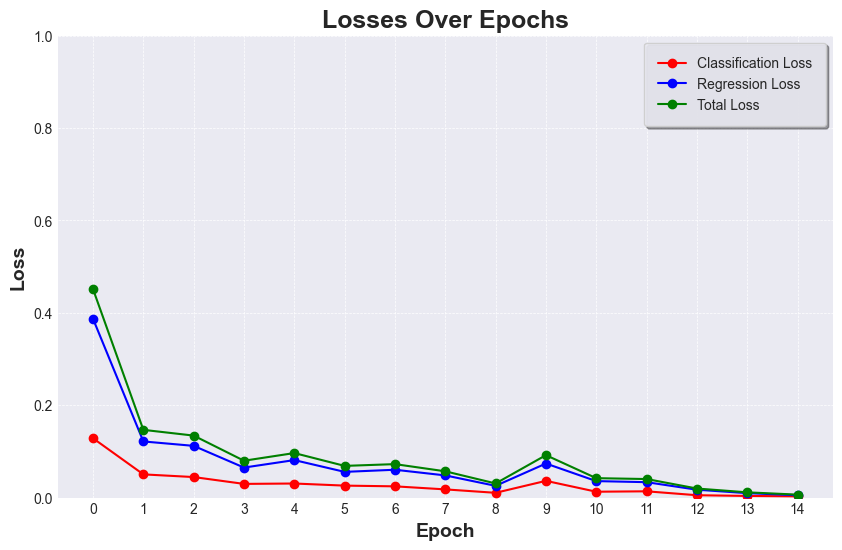

In [51]:
plt.style.use('seaborn-v0_8-darkgrid')
fig, ax = plt.subplots(figsize=(10, 6))


ax.plot(hist.history['class_loss'], color='red', marker='o', label='Classification Loss')
ax.plot(hist.history['regress_loss'], color='blue', marker='o', label='Regression Loss')
ax.plot(hist.history['total_loss'], color='green', marker='o', label='Total Loss')

ax.set_title('Losses Over Epochs', fontsize=18, fontweight='bold')
ax.set_xlabel('Epoch', fontsize=14, fontweight='bold')
ax.set_ylabel('Loss', fontsize=14, fontweight='bold')

ax.set_ylim([0, 1])

ax.set_xticks(np.arange(start=0, stop=len(hist.history['loss']), step=1))

ax.grid(True, which='both', linestyle='--', linewidth=0.5)

legend = ax.legend(frameon=True, framealpha=0.9, shadow=True, borderpad=1)

plt.show()

# Testing model

In [ ]:
# Testing on the test set
test_data = test.as_numpy_iterator()
test_sample = test_data.next()
yhat = model.predict(test_sample[0])

fig, ax = plt.subplots(ncols=4, figsize=(20,20))

for i in range(4):
    sample_image = test_sample[0][i].copy()  # Ensure that you're working with a copy of the image
    sample_coordinates = yhat[1][i]
    
    # Convert coordinates to integers
    coordinates_top_left = tuple(np.multiply(sample_coordinates[:2], [120,120]).astype(int))
    coordinates_bottom_right = tuple(np.multiply(sample_coordinates[2:], [120,120]).astype(int))
    
    if yhat[0][i] > 0.9:
        cv2.rectangle(sample_image, coordinates_top_left, coordinates_bottom_right, (255, 0, 0), 2)
    
    ax[i].imshow(sample_image)

In [54]:
# Testing on the stock video (data outside of val/test/train sets)
# https://mixkit.co/free-stock-video/influencer-waves-hello-to-subscribers-on-webcam-15909/
cap = cv2.VideoCapture('test_video.mp4')

# Getting the video stats
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

output = cv2.VideoWriter('test_video_done.avi', cv2.VideoWriter_fourcc(*'XVID'), fps, (frame_width, frame_height))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = model.predict(np.expand_dims(resized/255,0))
    sample_coordinates = yhat[1][0]
    
    if yhat[0] > 0.5: 
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coordinates[:2], [frame_width,frame_height]).astype(int)),
                      tuple(np.multiply(sample_coordinates[2:], [frame_width,frame_height]).astype(int)), 
                            (255,0,0), 2)
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coordinates[:2], [frame_width,frame_height]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coordinates[:2], [frame_width,frame_height]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coordinates[:2], [frame_width,frame_height]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    

    output.write(frame)   
    cv2.imshow('FaceTrack', frame)    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
output.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━

In [39]:
# Testing on the webcam
cap = cv2.VideoCapture(0) # Choose the device
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = model.predict(np.expand_dims(resized/255,0))
    sample_coordinates = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coordinates[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coordinates[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coordinates[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coordinates[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coordinates[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('FaceTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━

In [ ]:
# Saving the model
model.save('model/facetracker_V1.0.h5')